In [1]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal
import numpy as np

def reverse_url(url):
    components = str(url).split('.')
    reversed_url = '.'.join(components[::-1])
    return reversed_url

metric="pagerank_centrality"
casino_atr_file='/home/pcarragh/dev/link_scheme_removal/cc-webgraph/ranking/output/exp-scam-casino-discover-top.out.sorted'
news_atr_file='/home/pcarragh/dev/link_scheme_removal/cc-webgraph/ranking/output/exp-ls-atr-discover-top.out.sorted'
cc_rank_cols = ["harmonic_rank", "harmonic_centrality", "pagerank_rank", "pagerank_centrality", "url", "a"]

# Read pre and post rankings data
df_casino_atr = pd.read_csv(casino_atr_file, sep='\t', names=[col + '_casino' for col in cc_rank_cols])
df_news_atr = pd.read_csv(news_atr_file, sep='\t', names=[col + '_news' for col in cc_rank_cols])
# pre_rankings['url'] = pre_rankings['url'].apply(reverse_url)
# post_rankings['url'] = post_rankings['url'].apply(reverse_url)


# Filter columns
df_casino_atr = df_casino_atr.iloc[:, :-1]  # Drop last column
df_news_atr = df_news_atr.iloc[:, :-1]  # Drop last column

# Merge with domain labels data
df_atr_multi_domain = df_casino_atr.merge(df_news_atr, left_on='url_casino', right_on='url_news', how='inner')
df_atr_multi_domain.describe()


/tmp/ipykernel_2102317/612653649.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,harmonic_rank_casino,harmonic_centrality_casino,pagerank_rank_casino,pagerank_centrality_casino,harmonic_rank_news,harmonic_centrality_news,pagerank_rank_news,pagerank_centrality_news
count,6.037200e+04,6.032300e+04,60372.000000,6.037200e+04,6.037200e+04,6.031500e+04,60372.000000,6.037200e+04
mean,8.296808e+07,-4.505521e+34,44631.588038,6.152463e-06,8.267780e+07,-1.252479e+33,44795.780759,9.245541e-06
std,4.693939e+07,7.985712e+36,26977.417574,6.372654e-05,4.653121e+07,9.233203e+36,28340.940525,6.052923e-05
min,4.400000e+02,-3.347763e+38,1.000000,7.242591e-07,1.840000e+03,-3.325169e+38,1.000000,9.344816e-07
25%,4.905087e+07,0.000000e+00,21181.750000,1.135980e-06,4.896872e+07,0.000000e+00,20214.750000,1.376035e-06
50%,8.305465e+07,0.000000e+00,43225.500000,1.796360e-06,8.340463e+07,0.000000e+00,42770.500000,2.180398e-06
75%,1.062229e+08,7.820728e-02,65799.250000,3.876725e-06,1.067383e+08,8.423242e-02,68181.250000,4.498770e-06
max,1.878599e+08,3.259601e+38,99999.000000,8.122603e-03,1.878710e+08,3.345201e+38,99995.000000,7.105771e-03


Text(0.5, 1.0, 'Identification of Multi-Domain Link Schemes')

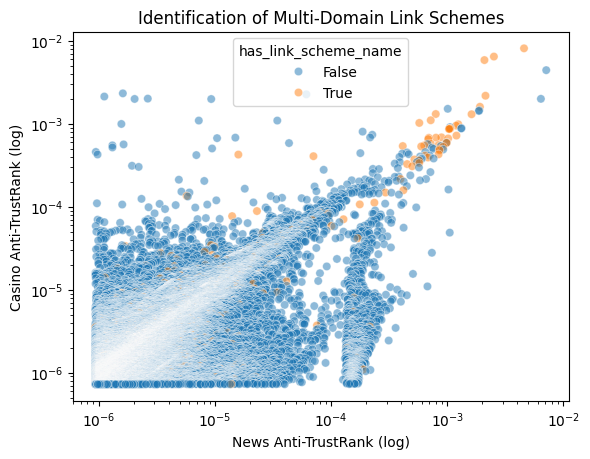

In [2]:
import seaborn as sns

def is_link_scheme_url(url):
    scheme_strs = ['seo','directory','rank','link','article','site']
    return any([scheme_str in url for scheme_str in scheme_strs])

df_atr_multi_domain['has_link_scheme_name'] = df_atr_multi_domain['url_news'].apply(is_link_scheme_url)

sns.scatterplot(df_atr_multi_domain, x='pagerank_centrality_news', y='pagerank_centrality_casino', hue='has_link_scheme_name', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Casino Anti-TrustRank (log)')
plt.xlabel('News Anti-TrustRank (log)')
plt.title('Identification of Multi-Domain Link Schemes')

In [17]:
df_atr_multi_domain_cut = df_atr_multi_domain[(df_atr_multi_domain['pagerank_centrality_news']>0.0002) & (df_atr_multi_domain['pagerank_centrality_casino']>0.0003)]
df_atr_multi_domain_cut['clickable_url'] = df_atr_multi_domain_cut['url_news'].apply(reverse_url)
df_atr_multi_domain_cut.to_csv('multi-domain-link-schemes-ranks.csv', index=False)
df_atr_multi_domain_cut.to_csv('multi-domain-link-schemes-urls.csv', index=False, columns=['url_news'])


/tmp/ipykernel_2912940/1119814454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atr_multi_domain_cut['clickable_url'] = df_atr_multi_domain_cut['url_news'].apply(reverse_url)


In [16]:
df_atr_multi_domain_cut_2 = df_atr_multi_domain[((df_atr_multi_domain['pagerank_centrality_news']<0.0002) | (df_atr_multi_domain['pagerank_centrality_casino']<0.0003)) & (df_atr_multi_domain['pagerank_centrality_news']>0.0001) & (df_atr_multi_domain['pagerank_centrality_casino']>0.0001)]
df_atr_multi_domain_cut_2['clickable_url'] = df_atr_multi_domain_cut_2['url_news'].apply(reverse_url)
# df_atr_multi_domain_cut.to_csv('multi-domain-link-schemes.csv', index=False)
df_atr_multi_domain_cut_2['clickable_url']

/tmp/ipykernel_2912940/1383030339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atr_multi_domain_cut_2['clickable_url'] = df_atr_multi_domain_cut_2['url_news'].apply(reverse_url)


95               pinterest.com
96               socialyta.com
97      milkywaygalaxynews.com
98                 kesbang.com
99              online-ads.org
                ...           
204           worldpreneur.com
206                  github.io
210          writingandseo.com
214                spotify.com
216    kasaranitechnical.ac.ke
Name: clickable_url, Length: 81, dtype: object